In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans, SpectralClustering

import umap

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src.downsample import downsamp_audio
import src.dimension_reducer as dr
import src.distance_metrics as dm
import src.emb_manipulator as em

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

#Directory where already-generated embeddings stored
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models. in any "all models" script we evaluate which one(s) might be best

##files starting with 020422 are from the recent recordings of actual moms sohye sent
## files starting with 020322 were all the test recordings from last year

#the directory has other csvs and i only want today's
#file = [file for file in os.listdir(embedding_dir) if file.startswith("020422")] 
#file = '022822_postpartum_moms_20part_emb_ami.csv'
file = '03016_diarized_pyv2.csv'

#create a dictionary where each item is the pd df of the embeddings extracted from that model
#all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}
emb = pd.read_csv(os.path.join(embedding_dir,file), index_col=0)

#choose 'emb_ami' as the embedding model to use because it seemed to result in best preserved high-dimension structure when dimension reduced
#emb = all_embs[emb_models[0]]
emb_down = em.resample_data(emb,1)

#average emebdding for each participant
emb_a = em.embedding_averager(emb_down)

#egemap (88 features) for each participant
#gemap_file = '040122_segmented_postpartum_moms_gemaps'
gemap_file = '040122_segmented_postpartum_moms_gemaps_2sec.csv'
#gemap_file = '040622_segmented_postpartum_moms_gemaps_5sec.csv'
gemap = pd.read_csv(os.path.join(embedding_dir,gemap_file), index_col=0)
gemap = gemap.drop(columns=['start','end'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
test_subset_labeled = emb_down.groupby('part_id').sample(n=5, random_state=42)
train_subset_labeled = emb_down.drop(test_subset_labeled.index)

#train = train_subset_labeled.reset_index(drop=True).drop(columns='part_id')
train = train_subset_labeled.drop(columns='part_id').to_numpy()
train_labels = train_subset_labeled.part_id.to_numpy()

#test = test_subset_labeled.reset_index(drop=True).drop(columns='part_id')
test = test_subset_labeled.drop(columns='part_id').to_numpy()
test_labels = test_subset_labeled.part_id.to_numpy()

#all_data = np.array(np.vstack([train, test]), dtype=np.float64)
#target = np.hstack([train_labels, test_labels])
classes = emb_down.part_id.unique().astype('int32')

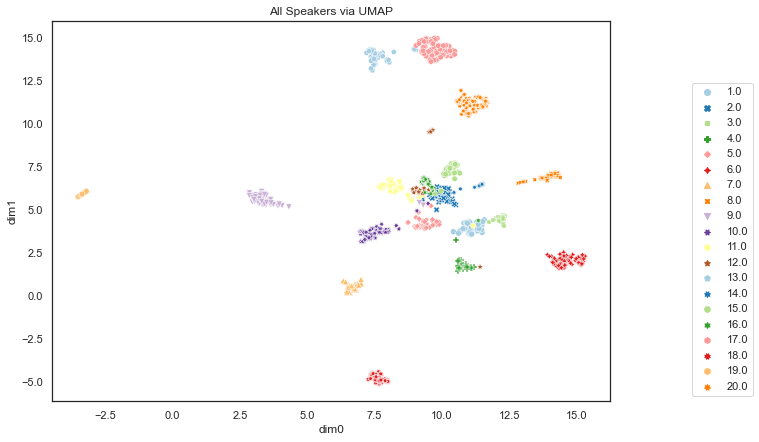

In [10]:
embedding = umap.UMAP(n_neighbors=10).fit_transform(emb_down.drop(columns='part_id'))
embedding = pd.DataFrame(embedding, columns={'dim0', 'dim1'})
embedding['part_id'] = emb_down['part_id'].to_numpy()

fig, ax = plt.subplots(1, figsize=(10, 7))
sns.scatterplot(x = embedding.dim0, y = embedding.dim1, palette="Paired", hue=embedding.part_id, style=embedding.part_id, legend=True)
ax.legend(loc="lower center",bbox_to_anchor=(1.2,0), ncol=1)
plt.title('All Speakers via UMAP');


In [20]:
train_embedding = umap.UMAP(n_neighbors=10).fit_transform(train)
mapper = umap.UMAP(n_neighbors=10).fit(train, train_labels)
train_embedding = pd.DataFrame(mapper.embedding_, columns={'dim0','dim1'})
train_embedding['part_id'] = train_labels
test_embedding = pd.DataFrame(mapper.transform(test), columns={'dim0','dim1'})
test_embedding['part_id'] = test_labels

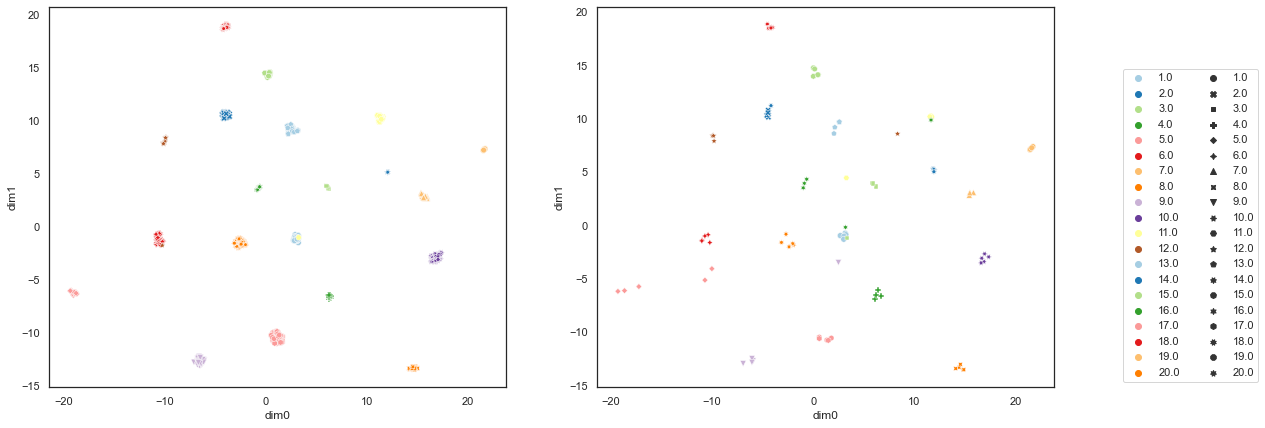

In [28]:
fig, ((ax1, ax2)) = plt.subplots(figsize=(18, 7), ncols=2)

train_plot = sns.scatterplot(x=train_embedding.dim0, y=train_embedding.dim1, 
                                 ax=ax1, palette="Paired", hue=train_embedding.part_id, style=train_labels, legend=True)

#metric_learn_train = sns.scatterplot(x=train_embedding.dim0, y=train_embedding.dim1, 
#                                ax=ax2, palette="Paired", hue=train_embedding.part_id, style=train_labels, legend=False)

metric_learn_test = sns.scatterplot(x=test_embedding.dim0, y=test_embedding.dim1, 
                                 ax=ax2, palette="Paired", hue=test_labels, style=test_labels, legend=False)
ax1.legend(loc="lower center",bbox_to_anchor=(2.5, 0), ncol=2)

In [31]:
train_haus = dm.hausdorff_distances(train_embedding)
metric_learning_haus = dm.hausdorff_distances(pd.concat([train_embedding, test_embedding]))
all_data_haus = dm.hausdorff_distances(embedding)

Processing row 19, col 19


In [36]:
all_data_haus

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,NaN,-0.870632,-1.215107,-1.227703,-0.992972,-1.092831,-0.733170,-0.777865,-0.739231,-0.709197,-1.155026,-0.519975,0.090650,-0.792315,-0.674586,-1.021898,-0.002334,-0.716204,0.054835,-0.254652
2,-0.848402,NaN,-0.830354,-0.761707,-1.143195,-0.578826,-0.573423,-0.785238,-1.236326,-1.213098,-0.974233,-1.041573,-0.433199,-1.171660,-1.259401,-1.019868,-0.418096,-0.333041,-0.625338,-0.643238
3,-1.273034,-0.780670,NaN,-1.023964,-0.751294,-1.313896,-0.471211,-1.104348,-0.541765,-0.539465,-0.992836,-0.360258,0.093755,-0.808055,-0.597506,-1.058569,-0.063770,-0.557673,0.508935,-0.362838
4,-0.898487,-0.328260,-0.774266,NaN,-0.636885,-1.160815,-1.250926,-0.270770,-0.228996,-0.382933,-0.542035,-0.874133,0.613152,-0.213160,-0.133294,-0.451155,0.548421,-1.158022,0.151683,0.375499
5,-1.007525,-1.037414,-0.783614,-1.044138,NaN,-0.630868,-0.991670,-0.501107,-1.223520,-1.213647,-0.859397,-0.764861,-0.155140,-0.809014,-0.904523,-0.741237,-0.118083,-0.665483,-0.925630,-0.284305
6,-0.340921,0.331461,-0.607417,-0.481787,0.288931,NaN,0.210693,-0.398692,0.772842,0.701756,0.106487,-0.037933,1.080245,0.191419,0.546994,0.041355,0.776866,-0.557926,2.446348,0.558109
7,-0.017379,0.342022,0.219144,-0.436907,-0.095581,-0.040912,NaN,0.681420,0.276419,-0.577194,0.512170,0.431634,0.860147,0.513036,0.506649,0.593125,0.977448,-1.953372,-1.943445,1.035088
8,-0.423823,-0.164001,-0.739650,-0.120337,0.068114,-0.852683,0.607285,NaN,0.226086,0.156036,0.026657,0.342788,-0.229869,-0.689291,-0.394047,-0.136668,-0.543845,0.361239,1.683204,-0.830917
9,0.710748,0.514697,0.866200,0.665688,0.396188,0.970450,-0.579197,0.962831,NaN,-0.005077,0.181229,0.776897,-0.313694,0.675324,0.587568,0.594746,0.097900,-0.200260,-1.345576,0.468519
10,-0.527697,-0.417127,-0.271052,-0.638939,-0.876599,-0.213868,-0.969056,0.064773,-0.577117,NaN,-0.418275,-0.223008,0.004196,-0.229447,-0.338080,-0.234793,0.169015,-0.632039,-1.241822,0.169320


In [ ]:
#train_haus.loc[part_to_train_on] = np.nan
#train_haus.sort_index(inplace=True)
#train_haus[part_to_train_on] = np.nan
#train_haus = train_haus.reindex(sorted(train_haus.columns), axis = 1)

#metric_learning_haus.sort_index(inplace=True)
#metric_learning_haus = metric_learning_haus.reindex(sorted(metric_learning_haus.columns), axis = 1)

In [37]:
part_list = emb_down.part_id.unique().astype('int32') 
train_haus_flat = np.hstack(
    (train_haus.to_numpy()[np.triu_indices(part_list.size, k=1)],
     train_haus.to_numpy()[np.tril_indices(part_list.size, k=-1)])
)

metric_learning_haus_flat = np.hstack(
    (metric_learning_haus.to_numpy()[np.triu_indices(part_list.size, k=1)],
     metric_learning_haus.to_numpy()[np.tril_indices(part_list.size, k=-1)])
)

all_data_haus_flat = np.hstack(
    (all_data_haus.to_numpy()[np.triu_indices(part_list.size, k=1)],
     all_data_haus.to_numpy()[np.tril_indices(part_list.size, k=-1)])
)

In [50]:
np.corrcoef(train_haus.to_numpy().flatten(),metric_learning_haus.to_numpy().flatten())

array([[nan, nan],
       [nan, nan]])

In [58]:
corr_coeff = pd.DataFrame()
#train_haus_flat_df = pd.DataFrame(train_haus_flat)
df_1 = pd.DataFrame(train_haus.to_numpy().flatten()).dropna()
df_2 = pd.DataFrame(all_data_haus.to_numpy().flatten()).dropna()

df_1.corrwith(df_2)

#metric_learning_haus_flat_df = pd.DataFrame(metric_learning_haus_flat)
#all_data_haus_flat_df = pd.DataFrame(all_data_haus_flat)
#corr_coeff = train_haus_flat_df.corrwith(metric_learning_haus_flat_df)
#corr_coeff = train_haus_flat_df.corrwith(all_data_haus_flat_df)
#corr_coeff
#for haus in loo_haus_tsne_flat.values():
#    haus = pd.DataFrame(haus)
#    corr_coeff = pd.concat([corr_coeff, haus_tsne_flat_df.corrwith(haus)], ignore_index=True)
#corr_coeff['rm'] = loo_haus_tsne_flat.keys()

0    0.138151
dtype: float64

<AxesSubplot:>

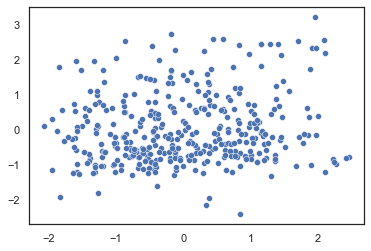

In [65]:
sns.scatterplot(x=train_haus.to_numpy().flatten(), y=all_data_haus.to_numpy().flatten()) 

In [ ]:
high_dim = emb_down.drop(columns='part_id').to_numpy()
labels= emb_down.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim = embedding
dist_umap = dm.embedding_quality(high_dim, low_dim, labels,subsetsize=emb_down.shape[0])

#metric learned comparison
low_dim = np.vstack((test_embedding,mapper.embedding_))
dist_umap_metric_learn = dm.embedding_quality(high_dim, low_dim, labels,subsetsize=emb_down.shape[0])

#of just the training data (before adding in the new speaker)
high_dim = train_data
low_dim = train_embedding
dist_umap_train_data = dm.embedding_quality(high_dim, low_dim, train_labels,subsetsize=train_data.shape[0])


In [75]:
np.vstack((dist_umap,dist_umap_metric_learn, dist_umap_train_data))

array([[0.10031056, 0.63      , 0.14645017],
       [0.41325052, 0.57      , 0.23985085],
       [0.43875546, 0.67894737, 0.38562493]])